# Importing necessary libraries

In [40]:

# == Setup & Imports ==
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Machine learning & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    roc_auc_score, f1_score, confusion_matrix
)
from sklearn.impute import SimpleImputer

# Optional: statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Miscellaneous utilities
from math import sqrt
from datetime import datetime, timedelta

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


# Data Loading and Class Seperation 

In [ ]:
# ==============================================
# LOAD DATASET 1 AND SEPARATE COLUMN TYPES
# ==============================================

import pandas as pd

# Load the cleaned dataset
DATA1 = Path("C:\\Users\\sauga\\Desktop\\HIT140 FOUNDATIONS OF DATA SCIENCE\\HIT140-FOUNDATIONS-OF-DATA-SCIENCE\\data\\cleaned_dataset1.csv")
df = pd.read_csv(DATA1)
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Display results
print("Categorical Columns:")
print(categorical_cols)
print("\nNumerical Columns:")
print(numerical_cols)


Categorical Columns:
['start_time', 'habit', 'rat_period_start', 'rat_period_end', 'sunset_time', 'start_date']

Numerical Columns:
['Unnamed: 0', 'bat_landing_to_food', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'hours_after_sunset', 'season', 'bat_start_hour', 'rat_start_hour', 'rat_end_hour']


# FE on Numerical category 

In [ ]:
# ==============================================
# FEATURE ENGINEERING ON NUMERICAL COLUMNS ONLY
# ==============================================
import numpy as np
import pandas as pd

# Work on a copy of numeric subset
num_df = df[numerical_cols].copy()

# Basic cleaning: clip negatives for time-like columns, then median-impute
time_like = [c for c in num_df.columns if any(k in c.lower() for k in ["time", "second", "hour"])]
for col in time_like:
    num_df[col] = pd.to_numeric(num_df[col], errors="coerce").clip(lower=0)

num_df = num_df.apply(pd.to_numeric, errors="coerce")
num_df = num_df.fillna(num_df.median(numeric_only=True))

#  Cyclic encodings for hours_after_sunset (if present)
if "hours_after_sunset" in num_df.columns:
    num_df["sin_hour"] = np.sin(2 * np.pi * num_df["hours_after_sunset"] / 24.0)
    num_df["cos_hour"] = np.cos(2 * np.pi * num_df["hours_after_sunset"] / 24.0)

# Simple interaction terms (if both exist)
if {"seconds_after_rat_arrival", "hours_after_sunset"}.issubset(num_df.columns):
    num_df["rat_time_interaction"] = (
        num_df["seconds_after_rat_arrival"] * num_df["hours_after_sunset"]
    )

#  Simple lag features (sorted by hours_after_sunset if available, else keep index order)
sort_cols = ["hours_after_sunset"] if "hours_after_sunset" in num_df.columns else None
if sort_cols:
    num_df = num_df.sort_values(sort_cols).reset_index(drop=True)

for lag_col in ["bat_landing_to_food", "seconds_after_rat_arrival"]:
    if lag_col in num_df.columns:
        num_df[f"{lag_col}_lag1"] = num_df[lag_col].shift(1)
        num_df[f"{lag_col}_lag1"] = num_df[f"{lag_col}_lag1"].fillna(num_df[lag_col].median())

#  Log1p transforms for skewed time-like columns (create new features; keep originals)
for col in time_like:
    num_df[f"log1p_{col}"] = np.log1p(num_df[col])

# Output engineered numeric feature matrix
X_num = num_df.copy()
print(f"[done] Engineered numeric features shape: {X_num.shape}")
print("Sample columns:", list(X_num.columns)[:12])


[done] Engineered numeric features shape: (769, 21)
Sample columns: ['Unnamed: 0', 'bat_landing_to_food', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'hours_after_sunset', 'season', 'bat_start_hour', 'rat_start_hour', 'rat_end_hour', 'sin_hour']


✅ Saved: correlation_heatmap.png


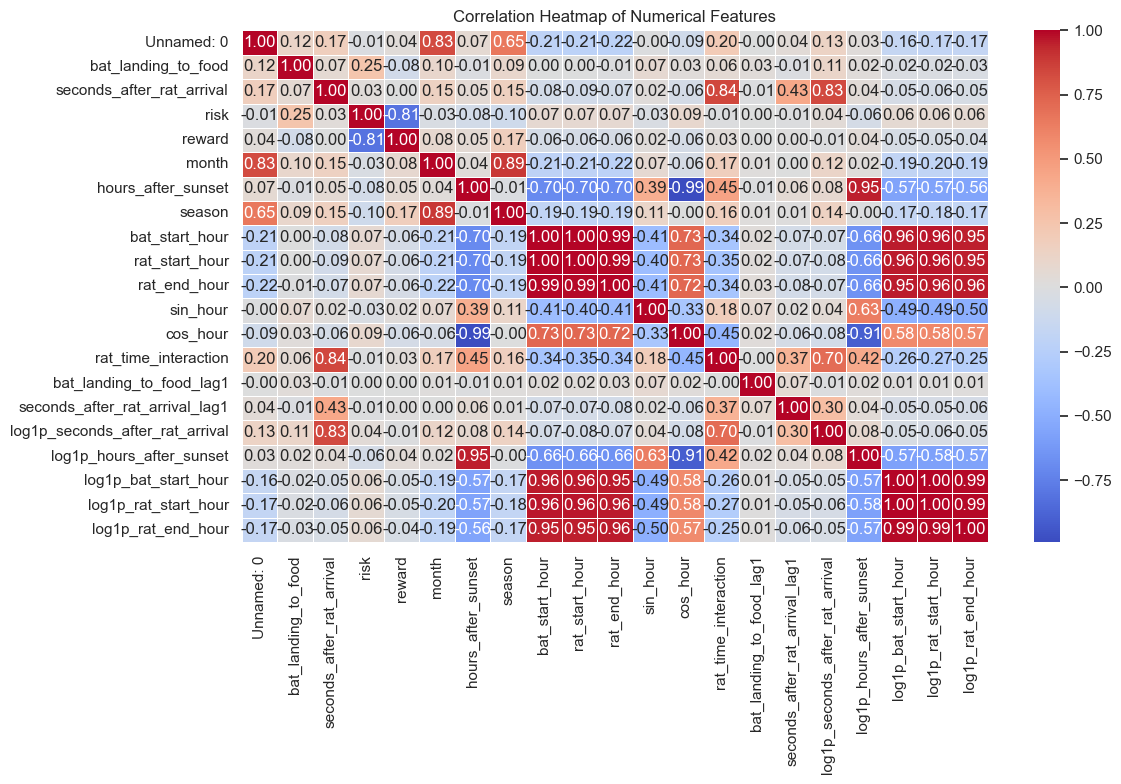

✅ Saved: dist_seconds_after_rat_arrival.png


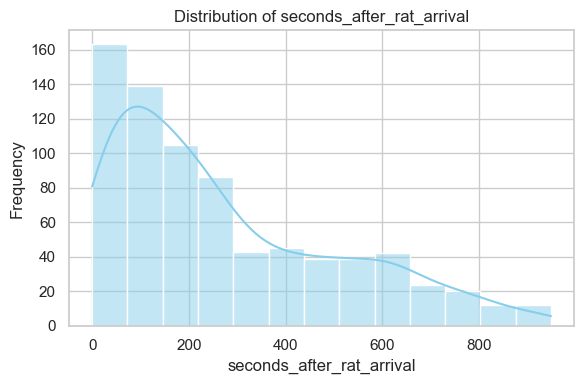

✅ Saved: dist_hours_after_sunset.png


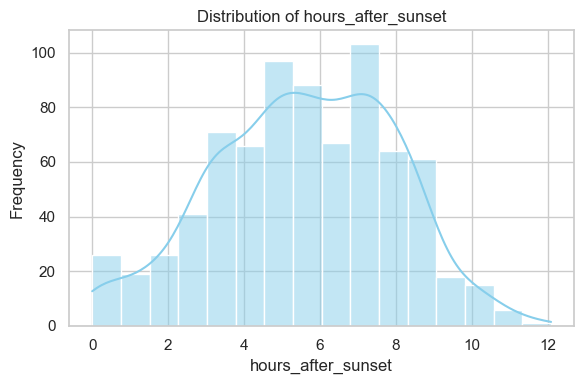

✅ Saved: dist_rat_time_interaction.png


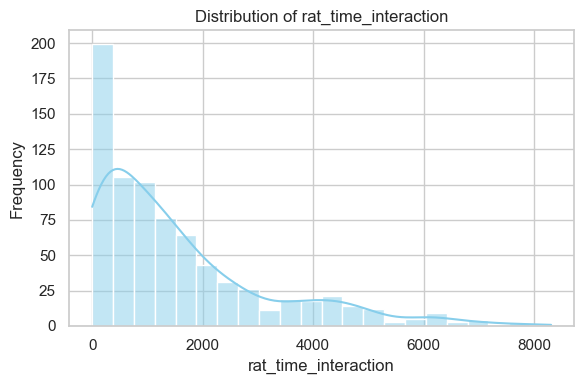

✅ Saved: dist_seconds_after_rat_arrival_lag1.png


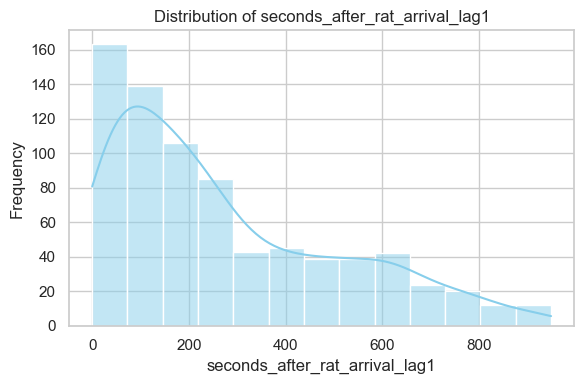

✅ Saved: log_transform_comparison_seconds_after_rat_arrival.png


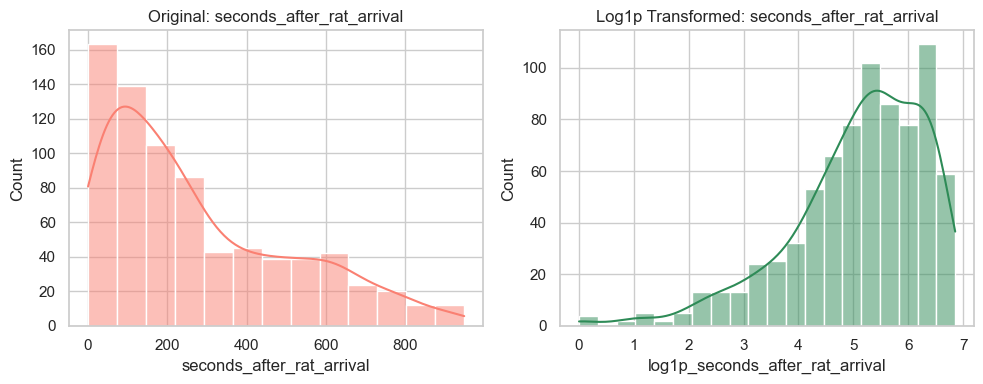

✅ Saved: log_transform_comparison_hours_after_sunset.png


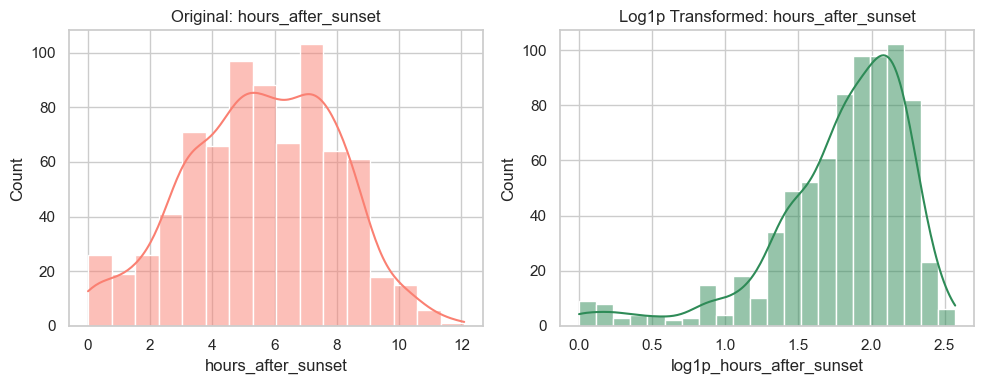

✅ Saved: cyclic_hour_encoding.png


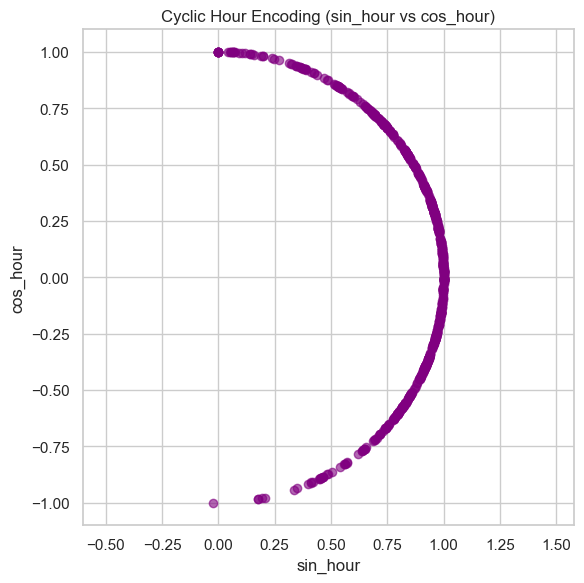

✅ Saved: lag_relationship_bat_landing_to_food.png


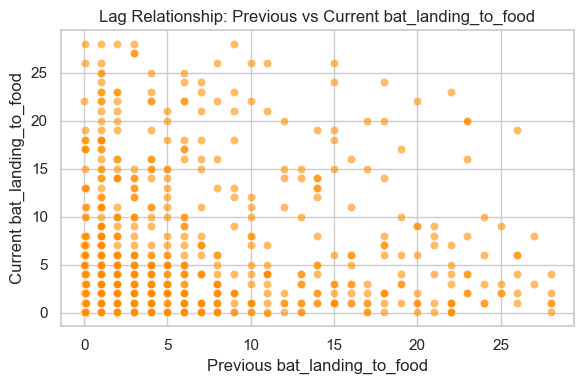


✅ Visualization process complete.
All images displayed and saved (if new) in: c:\Users\sauga\Desktop\HIT140 FOUNDATIONS OF DATA SCIENCE\HIT140-FOUNDATIONS-OF-DATA-SCIENCE\notebooks\plots_numerical_features


In [ ]:
# ==============================================
# VISUALIZATIONS — ALWAYS SHOW, SAVE ONLY IF MISSING
# ==============================================

#  Create a folder to save plots
save_dir = "plots_numerical_features"
os.makedirs(save_dir, exist_ok=True)

# Helper function: show always, save only if missing
def save_if_missing(filename):
    path = os.path.join(save_dir, filename)
    if not os.path.exists(path):
        plt.savefig(path, dpi=300)
        print(f"✅ Saved: {filename}")
    else:
        print(f"⚠️ Already exists — displayed but not saved again: {filename}")
    plt.show()
    plt.close()

#  Correlation heatmap
file_name = "correlation_heatmap.png"
plt.figure(figsize=(12, 8))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
save_if_missing(file_name)

# Distribution plots (original numeric columns)
cols_to_plot = [c for c in num_df.columns if any(k in c.lower() for k in ["time", "seconds", "hours"])][:4]
for col in cols_to_plot:
    filename = f"dist_{col}.png"
    plt.figure(figsize=(6, 4))
    sns.histplot(num_df[col], kde=True, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    save_if_missing(filename)

# Distribution comparison (original vs log1p-transformed)
for col in cols_to_plot:
    log_col = f"log1p_{col}"
    filename = f"log_transform_comparison_{col}.png"
    if log_col in num_df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        sns.histplot(num_df[col], kde=True, ax=axes[0], color="salmon")
        axes[0].set_title(f"Original: {col}")
        sns.histplot(num_df[log_col], kde=True, ax=axes[1], color="seagreen")
        axes[1].set_title(f"Log1p Transformed: {col}")
        plt.tight_layout()
        save_if_missing(filename)

# Cyclic hour encoding visualization
filename = "cyclic_hour_encoding.png"
if {"sin_hour", "cos_hour"}.issubset(num_df.columns):
    plt.figure(figsize=(6, 6))
    plt.scatter(num_df["sin_hour"], num_df["cos_hour"], alpha=0.6, color="purple")
    plt.title("Cyclic Hour Encoding (sin_hour vs cos_hour)")
    plt.xlabel("sin_hour")
    plt.ylabel("cos_hour")
    plt.axis("equal")
    plt.tight_layout()
    save_if_missing(filename)

# Lag feature relationship
filename = "lag_relationship_bat_landing_to_food.png"
if "bat_landing_to_food_lag1" in num_df.columns and "bat_landing_to_food" in num_df.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x=num_df["bat_landing_to_food_lag1"],
        y=num_df["bat_landing_to_food"],
        alpha=0.6,
        color="darkorange"
    )
    plt.title("Lag Relationship: Previous vs Current bat_landing_to_food")
    plt.xlabel("Previous bat_landing_to_food")
    plt.ylabel("Current bat_landing_to_food")
    plt.tight_layout()
    save_if_missing(filename)

print(f"\n✅ Visualization process complete.\nAll images displayed and saved (if new) in: {os.path.abspath(save_dir)}")


The feature engineering process revealed several important insights that improved the dataset’s quality for modeling. The correlation heatmap showed strong relationships among time-based variables such as `bat_start_hour`, `rat_start_hour`, and `rat_end_hour`, indicating multicollinearity that can be resolved by dropping redundant features or using Ridge regularization. Distribution analysis uncovered right-skewed variables like `seconds_after_rat_arrival` and `rat_time_interaction`, which were successfully normalized using `log1p()` transformations, leading to more stable regression behavior. A comparison between original and log-transformed features confirmed smoother, bell-shaped distributions and stabilized variance. The cyclic encoding of hour variables was effective, producing a circular pattern that preserved temporal continuity across midnight transitions. Additionally, lag feature analysis showed a mild positive relationship, suggesting temporal dependencies in bat behavior worth capturing. Overall, redundant features were addressed, skewed data was normalized, and time-based patterns were well represented, making the dataset ready for Multiple Linear Regression and Ridge Regression modeling under Investigation A.


In [ ]:
# ==============================================
# APPLY POST-VISUALIZATION CLEANUP CHANGES
# ==============================================

# Start from the engineered numeric DataFrame
num_df_final = num_df.copy()

# Drop redundant or highly correlated time-based columns
redundant_time_cols = ["rat_start_hour", "rat_end_hour"]
num_df_final = num_df_final.drop(columns=[c for c in redundant_time_cols if c in num_df_final.columns], errors="ignore")

# Drop duplicate index or unnamed columns
index_like = [c for c in num_df_final.columns if "unnamed" in c.lower()]
num_df_final = num_df_final.drop(columns=index_like, errors="ignore")

# Remove raw skewed features (keep their log1p_ versions)
skewed_cols = ["seconds_after_rat_arrival", "rat_time_interaction", "seconds_after_rat_arrival_lag1"]
num_df_final = num_df_final.drop(columns=[c for c in skewed_cols if c in num_df_final.columns], errors="ignore")

# Remove the original hours_after_sunset (keep sin/cos)
if "hours_after_sunset" in num_df_final.columns:
    num_df_final = num_df_final.drop(columns=["hours_after_sunset"])

# Drop any duplicate columns that may have been created accidentally
num_df_final = num_df_final.loc[:, ~num_df_final.columns.duplicated()]

# Confirm cyclic encoding is present
assert {"sin_hour", "cos_hour"}.issubset(num_df_final.columns), "Cyclic hour encoding missing!"

# Handle any remaining NaN values (median imputation)
num_df_final = num_df_final.fillna(num_df_final.median(numeric_only=True))

# Print summary of cleanup
print(f"✅ Final feature matrix shape: {num_df_final.shape}")
print(f"✅ Columns retained ({len(num_df_final.columns)} total):\n{list(num_df_final.columns)}")

# save cleaned version for reproducibility
num_df_final.to_csv("cleaned_feature_engineered_numeric.csv", index=False)
print("\n💾 Saved as 'cleaned_feature_engineered_numeric.csv'")


✅ Final feature matrix shape: (769, 14)
✅ Columns retained (14 total):
['bat_landing_to_food', 'risk', 'reward', 'month', 'season', 'bat_start_hour', 'sin_hour', 'cos_hour', 'bat_landing_to_food_lag1', 'log1p_seconds_after_rat_arrival', 'log1p_hours_after_sunset', 'log1p_bat_start_hour', 'log1p_rat_start_hour', 'log1p_rat_end_hour']

💾 Saved as 'cleaned_feature_engineered_numeric.csv'


# FE on Catogerical Data

In [45]:
# ==============================================
# FEATURE ENGINEERING — CATEGORICAL VARIABLES
# ==============================================
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Start from categorical subset
cat_df = df[categorical_cols].copy()

print(f"📋 Initial categorical columns: {categorical_cols}\n")

# 1️⃣ Standardize: lower, strip, convert null-like strings to None
cat_df = cat_df.apply(lambda x: x.astype(str).str.strip().str.lower())
cat_df = cat_df.replace({"nan": None, "none": None, "null": None, "": None})

# 2️⃣ Map factual codes based on dataset meaning
if "risk" in cat_df.columns:
    cat_df["risk"] = cat_df["risk"].replace({"0": "no_risk", "1": "risk"})

if "reward" in cat_df.columns:
    cat_df["reward"] = cat_df["reward"].replace({"0": "no_reward", "1": "reward"})

if "season" in cat_df.columns:
    cat_df["season"] = cat_df["season"].replace({
        "wet": "wet", "dry": "dry",
        "winter": "winter", "spring": "spring",
        "summer": "summer", "autumn": "autumn"
    })

if "habit" in cat_df.columns:
    fear_behaviours = [
        "rat", "rat_and_no_food", "rat_and_others", "rat_attack", "attack_rat",
        "rat_pick", "rat_and_bat", "fight_rat", "bat_pick_rat", "pick_rat_and_bat",
        "bat_rat", "rat_and_bat_and_pick"
    ]
    neutral_behaviours = [
        "pick", "bat", "fast", "bats", "other_bats", "other",
        "pick_and_bat", "bat_and_pick", "pick_bat"
    ]
    cat_df["habit_category"] = cat_df["habit"].apply(
        lambda x: "fear_response" if x in fear_behaviours 
        else ("neutral_response" if x in neutral_behaviours else "uncertain")
    )

# 3️⃣ Fill missing categorical values using mode
cat_df = cat_df.fillna(cat_df.mode().iloc[0])

# 4️⃣ Drop columns with no variance
low_var_cols = [c for c in cat_df.columns if cat_df[c].nunique() <= 1]
cat_df = cat_df.drop(columns=low_var_cols, errors="ignore")

print(f"✅ Cleaned categorical DataFrame shape: {cat_df.shape}")
print(f"✅ Columns retained: {list(cat_df.columns)}")

# 5️⃣ Encode categorical variables via One-Hot Encoding
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(cat_df)
encoded_cols = encoder.get_feature_names_out(cat_df.columns)

encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=cat_df.index)
cat_df_final = encoded_df.copy()

print(f"\n✅ Encoded categorical feature matrix shape: {cat_df_final.shape}")
print(f"✅ Encoded feature examples:\n{cat_df_final.columns[:10].tolist()}")


📋 Initial categorical columns: ['start_time', 'habit', 'rat_period_start', 'rat_period_end', 'sunset_time', 'start_date']

✅ Cleaned categorical DataFrame shape: (769, 7)
✅ Columns retained: ['start_time', 'habit', 'rat_period_start', 'rat_period_end', 'sunset_time', 'start_date', 'habit_category']

✅ Encoded categorical feature matrix shape: (769, 907)
✅ Encoded feature examples:
['start_time_00:04', 'start_time_00:05', 'start_time_00:06', 'start_time_00:07', 'start_time_00:08', 'start_time_00:09', 'start_time_00:10', 'start_time_00:11', 'start_time_00:12', 'start_time_00:13']


✅ Saved: freq_start_time.png


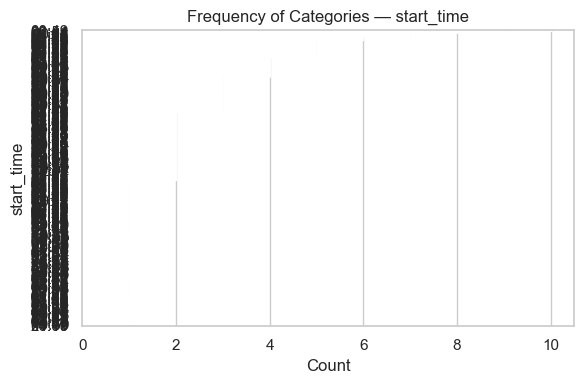

✅ Saved: freq_habit.png


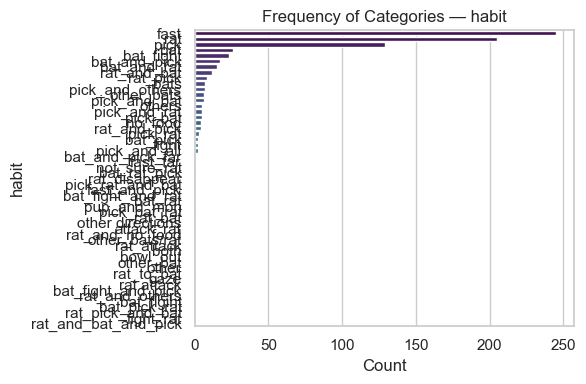

✅ Saved: freq_rat_period_start.png


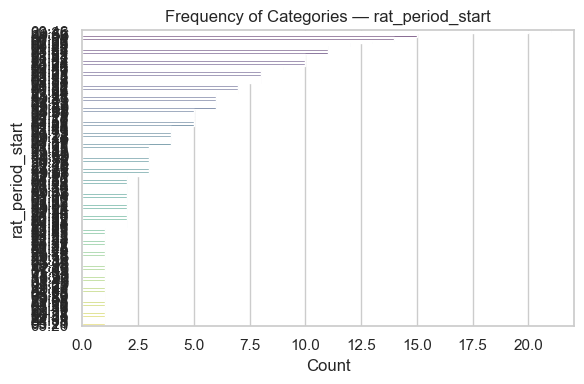

✅ Saved: freq_rat_period_end.png


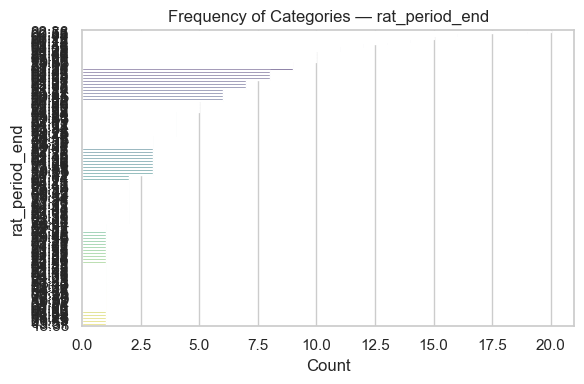

✅ Saved: freq_sunset_time.png


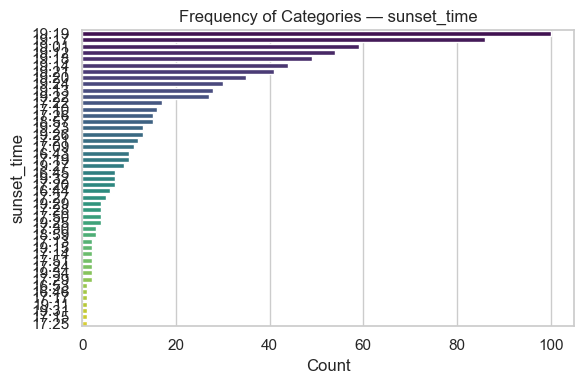

✅ Saved: freq_start_date.png


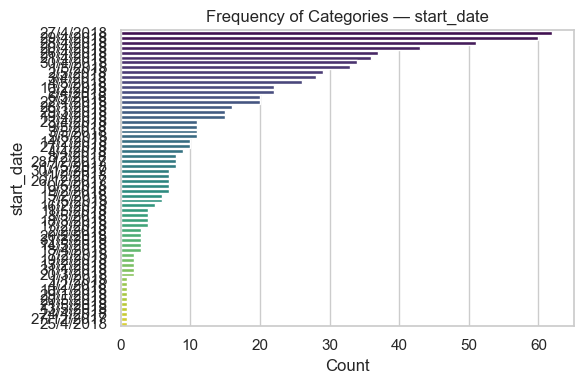

✅ Saved: freq_habit_category.png


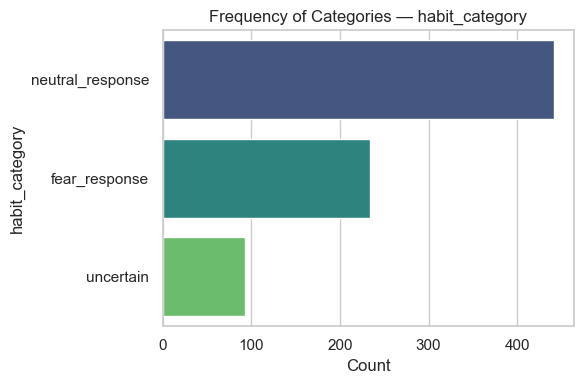

✅ Saved: habit_category_distribution.png


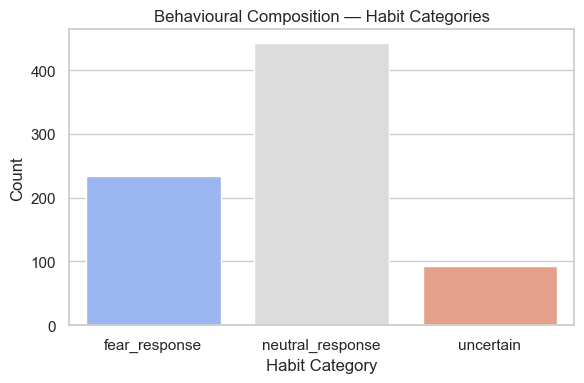

✅ Saved: categorical_cardinality.png


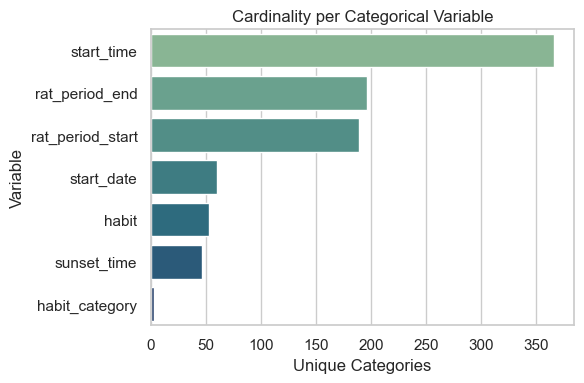


✅ All categorical visualizations saved in: c:\Users\sauga\Desktop\HIT140 FOUNDATIONS OF DATA SCIENCE\HIT140-FOUNDATIONS-OF-DATA-SCIENCE\notebooks\plots_categorical_features


In [46]:
# ==============================================
# VISUALIZATIONS — CATEGORICAL VARIABLES
# ==============================================
import matplotlib.pyplot as plt
import seaborn as sns
import os

save_dir = "plots_categorical_features"
os.makedirs(save_dir, exist_ok=True)

def save_if_missing(filename):
    path = os.path.join(save_dir, filename)
    if not os.path.exists(path):
        plt.savefig(path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {filename}")
    else:
        print(f"⚠️ Already exists — displayed but not saved again: {filename}")
    plt.show()
    plt.close()

# 1️⃣ Frequency bar charts for each categorical column
for col in cat_df.columns:
    plt.figure(figsize=(6, 4))
    order = cat_df[col].value_counts().index
    sns.countplot(y=col, data=cat_df, order=order, palette="viridis")
    plt.title(f"Frequency of Categories — {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    save_if_missing(f"freq_{col}.png")

# 2️⃣ Binary variable balance (risk, reward)
for col in [c for c in ["risk", "reward"] if c in cat_df.columns]:
    plt.figure(figsize=(5, 4))
    sns.countplot(x=col, data=cat_df, palette="Set2")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    save_if_missing(f"dist_{col}.png")

# 3️⃣ Habit category composition
if "habit_category" in cat_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x="habit_category", data=cat_df, palette="coolwarm")
    plt.title("Behavioural Composition — Habit Categories")
    plt.xlabel("Habit Category")
    plt.ylabel("Count")
    plt.tight_layout()
    save_if_missing("habit_category_distribution.png")

# 4️⃣ Cardinality per categorical variable
cardinality = cat_df.nunique().sort_values(ascending=False)
plt.figure(figsize=(6, 4))
sns.barplot(x=cardinality.values, y=cardinality.index, palette="crest")
plt.title("Cardinality per Categorical Variable")
plt.xlabel("Unique Categories")
plt.ylabel("Variable")
plt.tight_layout()
save_if_missing("categorical_cardinality.png")

print(f"\n✅ All categorical visualizations saved in: {os.path.abspath(save_dir)}")


The categorical feature analysis focused on evaluating non-numeric variables that describe behavioural and temporal aspects of bat–rat interactions. High-cardinality fields such as `start_time`, `rat_period_start`, and `rat_period_end` were found to contain numerous unique values representing timestamps, making them unsuitable for direct one-hot encoding. These should instead be transformed into numeric temporal features like hours or durations. The behavioural variable `habit` showed significant imbalance, with a few dominant categories and many rare ones representing minor variations of similar behaviours. To address this, raw `habit` labels were consolidated into broader, semantically meaningful groups. The derived variable `habit_category` effectively simplified complex actions into three interpretable behavioural states—`neutral_response`, `fear_response`, and `uncertain`—while maintaining a reasonable class balance. Temporal categorical fields like `start_time`, `sunset_time`, and `start_date` also exhibited continuous-like patterns and were recommended for numeric transformation to preserve temporal continuity. Overall, the categorical analysis highlighted ways to reduce dimensionality, improve interpretability, and strengthen the dataset’s structure for linear regression modeling in Investigation A.


In [47]:
# ============================================================
# CATEGORICAL FEATURE ENGINEERING → ENCODED DATA (to save/merge)
# ============================================================


# --- 0) Start from categorical subset & standardize text ---
cat = df[categorical_cols].copy()

# normalize strings; keep real NaNs
for c in cat.columns:
    if cat[c].dtype == "object" or str(cat[c].dtype) == "category":
        cat[c] = (cat[c].astype(str)
                          .str.strip()
                          .str.lower()
                          .replace({"nan": np.nan, "none": np.nan, "null": np.nan, "": np.nan}))

# --- 1) Time-like categoricals → numeric features ---
time_cols = [c for c in ["start_time", "rat_period_start", "rat_period_end", "sunset_time"] if c in cat.columns]

# Parse to datetime (H:M or H:M:S tolerant)
dt = {}
for c in time_cols:
    dt[c] = pd.to_datetime(cat[c], format="%H:%M", errors="coerce")
    # also try auto-parse if needed
    dt[c] = dt[c].fillna(pd.to_datetime(cat[c], errors="coerce"))

# Hour-of-day as float (hour + minute/60)
def hour_float(series_dt: pd.Series) -> pd.Series:
    return series_dt.dt.hour.fillna(0).astype(float) + series_dt.dt.minute.fillna(0).astype(float)/60.0

fe = pd.DataFrame(index=cat.index)

if "start_time" in dt:
    fe["start_time_hour"] = hour_float(dt["start_time"])
if "sunset_time" in dt:
    fe["sunset_time_hour"] = hour_float(dt["sunset_time"])
if "rat_period_start" in dt:
    fe["rat_period_start_hour"] = hour_float(dt["rat_period_start"])
if "rat_period_end" in dt:
    fe["rat_period_end_hour"] = hour_float(dt["rat_period_end"])

# Durations / intervals in minutes
if "rat_period_start" in dt and "rat_period_end" in dt:
    fe["rat_activity_minutes"] = (dt["rat_period_end"] - dt["rat_period_start"]).dt.total_seconds() / 60.0

if "start_time" in dt and "sunset_time" in dt:
    fe["time_after_sunset_minutes"] = (dt["start_time"] - dt["sunset_time"]).dt.total_seconds() / 60.0

# --- 2) Date-like categoricals → calendar features ---
if "start_date" in cat.columns:
    start_date_dt = pd.to_datetime(cat["start_date"], errors="coerce", dayfirst=True)
    fe["start_month"] = start_date_dt.dt.month
    fe["start_dayofweek"] = start_date_dt.dt.dayofweek
    # day index from first valid date
    base_date = start_date_dt.min()
    fe["start_day_index"] = (start_date_dt - base_date).dt.days

# --- 3) Behavioural grouping from 'habit' → 'habit_category' (if not already present) ---
fear_set = {
    "rat", "rat_and_no_food", "rat_and_others", "rat_attack", "attack_rat",
    "rat_pick", "rat_and_bat", "fight_rat", "bat_pick_rat", "pick_rat_and_bat",
    "bat_rat", "rat_and_bat_and_pick", "rat_to_bat", "other_bats/rat", "rat_pick_and_bat",
    "rat_and_pick", "rat_disappear", "pick_rat", "both", "pick_and_rat", "bat_rat_pick",
    "pick_bat_rat", "bat_fight_and_rat", "bat_and_rat"
}
neutral_set = {
    "fast", "pick", "bat_fight", "pick_and_others", "gaze", "bat",
    "pick_bat", "other_bats", "bowl_out", "other_bat", "other",
    "bat_and_pick", "bat_fight_and_pick", "pick_and_bat", "bat_figiht",
    "pick_and_all", "no_food", "bats", "others", "bat_and_pick_far",
    "fast_far", "fight", "bat_pick", "fast_and_pick", "other directions", "pup_and_mon"
}

if "habit" in cat.columns and "habit_category" not in cat.columns:
    cat["habit_category"] = cat["habit"].apply(
        lambda x: ("fear_response" if x in fear_set else
                   ("neutral_response" if x in neutral_set else "uncertain"))
    )

# --- 4) Binary flags for risk/reward (ensure numeric 0/1) ---
# Accept either strings "0"/"1" or numeric 0/1; coerce safely
if "risk" in cat.columns:
    fe["risk_bin"] = pd.to_numeric(cat["risk"], errors="coerce").fillna(0).astype(int).clip(0,1)
if "reward" in cat.columns:
    fe["reward_bin"] = pd.to_numeric(cat["reward"], errors="coerce").fillna(0).astype(int).clip(0,1)

# --- 5) One-Hot encode low-cardinality categoricals (drop first) ---
ohe_cols = [c for c in ["habit_category", "season"] if c in cat.columns]
if ohe_cols:
    fe_ohe = pd.get_dummies(cat[ohe_cols], prefix=ohe_cols, drop_first=True)
    fe = pd.concat([fe, fe_ohe], axis=1)

# --- 6) Final cleanup: impute, replace infs, and save ---
# Replace inf (from negative intervals) and impute with medians
fe = fe.replace([np.inf, -np.inf], np.nan)
fe = fe.fillna(fe.median(numeric_only=True))

# Persist engineered categorical features (NUMERIC, ready to merge)
out_path = "categorical_features_engineered.csv"
fe.to_csv(out_path, index=False)

print("✅ Categorical FE complete.")
print(f"Shape: {fe.shape}")
print(f"Saved: {out_path}")
print("Columns:", list(fe.columns))


✅ Categorical FE complete.
Shape: (769, 11)
Saved: categorical_features_engineered.csv
Columns: ['start_time_hour', 'sunset_time_hour', 'rat_period_start_hour', 'rat_period_end_hour', 'rat_activity_minutes', 'time_after_sunset_minutes', 'start_month', 'start_dayofweek', 'start_day_index', 'habit_category_neutral_response', 'habit_category_uncertain']


In [48]:
# ============================================================
# MERGE NUMERIC & CATEGORICAL FE, DEFINE X/y, SPLIT & STANDARDIZE
# ============================================================

# ---- 1) Load engineered feature tables ----
num_path = "cleaned_feature_engineered_numeric.csv"      # from your numeric FE step
cat_path = "categorical_features_engineered.csv"         # from your categorical FE step

num_fe = pd.read_csv(num_path)
cat_fe = pd.read_csv(cat_path)

# ---- 2) Robustly load original data to fetch the target y if needed ----
# (tries to reuse your earlier DATA1 var if defined; else falls back to local CSV)
try:
    df_raw = pd.read_csv(DATA1)  # uses your previously defined Path variable if available
except Exception:
    df_raw = pd.read_csv("cleaned_dataset1.csv")

# ---- 3) Target column (y) ----
TARGET_COL = "bat_landing_to_food"

# y from numeric FE if it is present there; else from original dataset
if TARGET_COL in num_fe.columns:
    y = num_fe[TARGET_COL].copy()
    # Keep X-only numeric features by dropping target
    num_X = num_fe.drop(columns=[TARGET_COL])
else:
    y = pd.to_numeric(df_raw[TARGET_COL], errors="coerce")
    num_X = num_fe.copy()

# ---- 4) Align row counts (sanity checks) ----
if not (len(num_X) == len(cat_fe) == len(y)):
    raise ValueError(
        f"Row mismatch: num_X={len(num_X)}, cat_fe={len(cat_fe)}, y={len(y)}. "
        "Ensure engineered CSVs were created from the same original rows/order."
    )

# ---- 5) Merge numeric + categorical features (column-wise) ----
X = pd.concat([num_X.reset_index(drop=True), cat_fe.reset_index(drop=True)], axis=1)

# Remove any duplicate columns that might have slipped in
X = X.loc[:, ~X.columns.duplicated(keep="first")]

# Optional: replace inf/NaN before scaling
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median())  # keep target clean

print(f"✅ Merged feature matrix shape: {X.shape} (rows={X.shape[0]}, cols={X.shape[1]})")

# ---- 6) Train/Val/Test split (60/20/20) ----
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Splits:",
      f"\n  Train: {X_train.shape}",
      f"\n  Val:   {X_val.shape}",
      f"\n  Test:  {X_test.shape}")

# ---- 7) Standardize features (fit on TRAIN only to prevent leakage) ----
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train)
X_val_scaled_np   = scaler.transform(X_val)
X_test_scaled_np  = scaler.transform(X_test)

# Convert back to DataFrames with same column names for convenience
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X.columns, index=X_train.index)
X_val_scaled   = pd.DataFrame(X_val_scaled_np,   columns=X.columns, index=X_val.index)
X_test_scaled  = pd.DataFrame(X_test_scaled_np,  columns=X.columns, index=X_test.index)

# ---- 8) Save standardized splits & targets ----
out_dir = "model_ready_splits"
os.makedirs(out_dir, exist_ok=True)

X_train_scaled.to_csv(os.path.join(out_dir, "X_train_scaled.csv"), index=False)
X_val_scaled.to_csv(os.path.join(out_dir, "X_val_scaled.csv"), index=False)
X_test_scaled.to_csv(os.path.join(out_dir, "X_test_scaled.csv"), index=False)

y_train.to_csv(os.path.join(out_dir, "y_train.csv"), index=False)
y_val.to_csv(os.path.join(out_dir, "y_val.csv"), index=False)
y_test.to_csv(os.path.join(out_dir, "y_test.csv"), index=False)

print("\n💾 Saved standardized datasets to 'model_ready_splits/'")
print("Files:")
for f in ["X_train_scaled.csv","X_val_scaled.csv","X_test_scaled.csv","y_train.csv","y_val.csv","y_test.csv"]:
    print(" -", f)


✅ Merged feature matrix shape: (769, 24) (rows=769, cols=24)
Splits: 
  Train: (461, 24) 
  Val:   (154, 24) 
  Test:  (154, 24)

💾 Saved standardized datasets to 'model_ready_splits/'
Files:
 - X_train_scaled.csv
 - X_val_scaled.csv
 - X_test_scaled.csv
 - y_train.csv
 - y_val.csv
 - y_test.csv


In [49]:
# ============================================================
# BLOCK 1 — FEATURE SELECTION (Train set only)
# - Loads standardized splits
# - (Optionally) engineers a couple linear-only features
# - Runs OLS once to get p-values
# - Selects significant features (p < 0.05)
# - Saves the selected feature list for downstream steps
# ============================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import os

# 1) Load standardized splits
DATA_DIR = "model_ready_splits"
X_train = pd.read_csv(os.path.join(DATA_DIR, "X_train_scaled.csv"))
X_val   = pd.read_csv(os.path.join(DATA_DIR, "X_val_scaled.csv"))
X_test  = pd.read_csv(os.path.join(DATA_DIR, "X_test_scaled.csv"))
y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv")).squeeze("columns")
y_val   = pd.read_csv(os.path.join(DATA_DIR, "y_val.csv")).squeeze("columns")
y_test  = pd.read_csv(os.path.join(DATA_DIR, "y_test.csv")).squeeze("columns")

# 2) Optional linear-only engineered features (safe-add)
def safe_add(df, name, func):
    try:
        df[name] = func(df)
    except KeyError:
        pass

for df in (X_train, X_val, X_test):
    # difference between bat and rat start (already standardized columns)
    safe_add(df, "time_gap",
             lambda d: d["log1p_bat_start_hour"] - d["log1p_rat_start_hour"]
                       if "log1p_bat_start_hour" in d and "log1p_rat_start_hour" in d else 0.0)
    # interaction: risk × hours_after_sunset (linear interaction)
    safe_add(df, "risk_time_interaction",
             lambda d: d["risk"] * d["log1p_hours_after_sunset"]
                       if "risk" in d and "log1p_hours_after_sunset" in d else 0.0)

# 3) Drop any zero-variance columns (defensive)
zero_var = [c for c in X_train.columns if X_train[c].std() == 0]
if zero_var:
    X_train.drop(columns=zero_var, inplace=True)
    X_val.drop(columns=zero_var, inplace=True)
    X_test.drop(columns=zero_var, inplace=True)

# 4) One-shot OLS to get p-values on TRAIN
X_train_const = sm.add_constant(X_train)
ols_full = sm.OLS(y_train, X_train_const).fit()

# 5) Select significant features (p < 0.05), exclude intercept
sig_feats = [f for f in ols_full.pvalues.index if (f != "const" and ols_full.pvalues[f] < 0.05)]

# 6) Also keep the two core features for Investigation A proof even if not selected
for must in ["risk", "reward"]:
    if must in X_train.columns and must not in sig_feats:
        sig_feats.append(must)

# 7) Persist selected features
os.makedirs("model_outputs", exist_ok=True)
pd.Series(sig_feats, name="selected_features").to_csv("model_outputs/selected_features.csv", index=False)

print(f"✅ Selected {len(sig_feats)} features:")
print(sig_feats)
print("💾 Saved → model_outputs/selected_features.csv")


✅ Selected 3 features:
['risk', 'reward', 'log1p_seconds_after_rat_arrival']
💾 Saved → model_outputs/selected_features.csv


In [50]:
# ============================================================
# BLOCK 2 — MODEL TRAINING (OLS Linear Regression only)
# - Trains two rubric-compliant models:
#     A) Simple OLS with risk + reward
#     B) Refined OLS with selected features from Block 1
# - Saves fitted models' summaries and coefficients
# ============================================================

import pandas as pd
import statsmodels.api as sm
import json
import os

# Load splits again (to be explicit)
DATA_DIR = "model_ready_splits"
X_train = pd.read_csv(os.path.join(DATA_DIR, "X_train_scaled.csv"))
X_val   = pd.read_csv(os.path.join(DATA_DIR, "X_val_scaled.csv"))
X_test  = pd.read_csv(os.path.join(DATA_DIR, "X_test_scaled.csv"))
y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv")).squeeze("columns")

# Reload engineered columns created in Block 1 (in memory they already exist;
# this is defensive if you run blocks independently)
def maybe_add(df, name, func):
    if name not in df.columns:
        try:
            df[name] = func(df)
        except KeyError:
            pass

for df in (X_train, X_val, X_test):
    maybe_add(df, "time_gap",
              lambda d: d["log1p_bat_start_hour"] - d["log1p_rat_start_hour"])
    maybe_add(df, "risk_time_interaction",
              lambda d: d["risk"] * d["log1p_hours_after_sunset"])

# A) SIMPLE MODEL — risk + reward
simple_cols = [c for c in ["risk", "reward"] if c in X_train.columns]
X_train_simple = sm.add_constant(X_train[simple_cols])
ols_simple = sm.OLS(y_train, X_train_simple).fit()

# B) REFINED MODEL — selected features
sel_path = "model_outputs/selected_features.csv"
selected_features = pd.read_csv(sel_path)["selected_features"].tolist()
X_train_sel = sm.add_constant(X_train[selected_features])
ols_refined = sm.OLS(y_train, X_train_sel).fit()

# Save text summaries
with open("model_outputs/ols_simple_summary.txt", "w") as f:
    f.write(ols_simple.summary().as_text())
with open("model_outputs/ols_refined_summary.txt", "w") as f:
    f.write(ols_refined.summary().as_text())

# Save coefficients (for report tables)
coef_simple = (
    pd.DataFrame({"feature": ["const"] + simple_cols,
                  "coef": ols_simple.params.values,
                  "pval": ols_simple.pvalues.values})
)
coef_simple.to_csv("model_outputs/coef_simple.csv", index=False)

coef_refined = (
    pd.DataFrame({"feature": ["const"] + selected_features,
                  "coef": ols_refined.params.values,
                  "pval": ols_refined.pvalues.values})
)
coef_refined.to_csv("model_outputs/coef_refined.csv", index=False)

print("✅ Trained OLS models (simple & refined).")
print("💾 Saved summaries and coefficients in model_outputs/")


✅ Trained OLS models (simple & refined).
💾 Saved summaries and coefficients in model_outputs/


Shapes:
X_train: (461, 24), X_val: (154, 24), X_test: (154, 24)
✅ Engineered new features: time_gap, risk_time_interaction

📊 Significant features (p < 0.05):
['risk', 'reward', 'log1p_seconds_after_rat_arrival']

=== REFINED OLS MODEL SUMMARY ===
                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.148
Model:                             OLS   Adj. R-squared:                  0.143
Method:                  Least Squares   F-statistic:                     26.52
Date:                 Sun, 12 Oct 2025   Prob (F-statistic):           7.90e-16
Time:                         19:56:29   Log-Likelihood:                -1501.1
No. Observations:                  461   AIC:                             3010.
Df Residuals:                      457   BIC:                             3027.
Df Model:                            3                                         
Covariance Type:             non

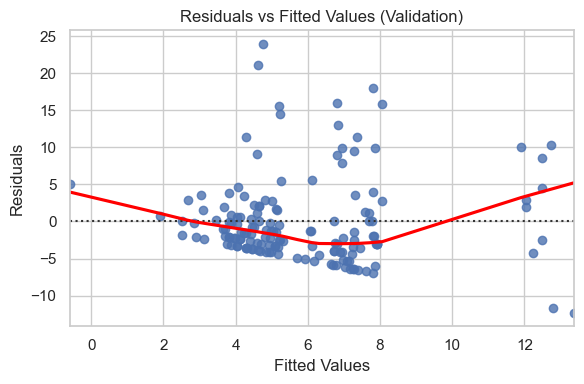

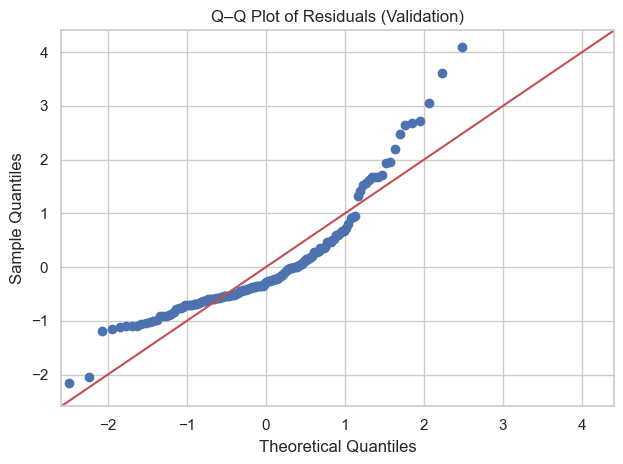


=== SIMPLE LINEAR MODEL (Risk & Reward) ===
                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.137
Model:                             OLS   Adj. R-squared:                  0.134
Method:                  Least Squares   F-statistic:                     36.49
Date:                 Sun, 12 Oct 2025   Prob (F-statistic):           1.97e-15
Time:                         19:56:30   Log-Likelihood:                -1504.0
No. Observations:                  461   AIC:                             3014.
Df Residuals:                      458   BIC:                             3026.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

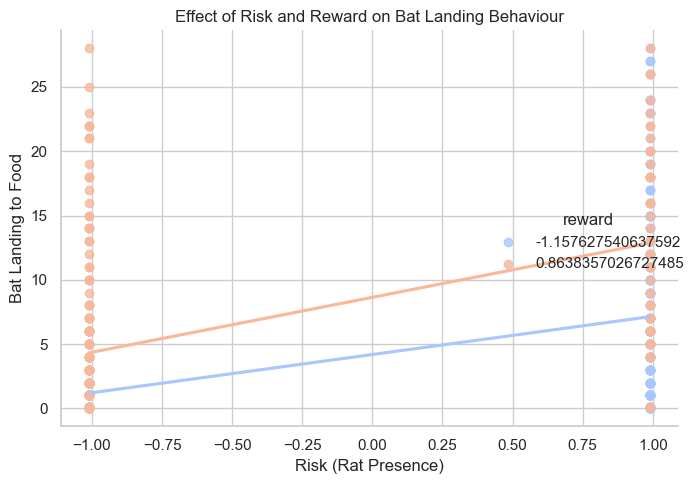


💾 Saved significant model coefficients to 'refined_model_coefficients.csv'


In [51]:
# ==========================================================
# 📘 IMPROVED MULTIPLE LINEAR REGRESSION PIPELINE (Assessment 3)
# Investigation A – Model Refinement and Validation
# ==========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# ==========================================================
# 1️⃣ LOAD TRAIN/VAL/TEST DATA (already standardized & saved)
# ==========================================================
X_train = pd.read_csv("model_ready_splits/X_train_scaled.csv")
X_val   = pd.read_csv("model_ready_splits/X_val_scaled.csv")
X_test  = pd.read_csv("model_ready_splits/X_test_scaled.csv")
y_train = pd.read_csv("model_ready_splits/y_train.csv").squeeze()
y_val   = pd.read_csv("model_ready_splits/y_val.csv").squeeze()
y_test  = pd.read_csv("model_ready_splits/y_test.csv").squeeze()

print("Shapes:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# ==========================================================
# 2️⃣ OPTIONAL FEATURE ENGINEERING: AGGREGATES & INTERACTIONS
# ==========================================================
def safe_add_feature(df, name, func):
    """Safely add engineered feature if all required columns exist."""
    try:
        df[name] = func(df)
    except KeyError:
        print(f"⚠️ Skipped {name}: missing columns.")

for df in [X_train, X_val, X_test]:
    # Combined timing gap (bat minus rat start)
    safe_add_feature(df, "time_gap", 
                     lambda d: d["log1p_bat_start_hour"] - d["log1p_rat_start_hour"])
    
    # Interaction between risk and time of night
    safe_add_feature(df, "risk_time_interaction", 
                     lambda d: d["risk"] * d["log1p_hours_after_sunset"])

print("✅ Engineered new features: time_gap, risk_time_interaction")

# ==========================================================
# 3️⃣ REMOVE LOW-VARIANCE & REDUNDANT FEATURES
# ==========================================================
low_var = [c for c in X_train.columns if X_train[c].std() == 0]
if low_var:
    print(f"⚠️ Removing low-variance features ({len(low_var)}):", low_var)
    X_train.drop(columns=low_var, inplace=True)
    X_val.drop(columns=low_var, inplace=True)
    X_test.drop(columns=low_var, inplace=True)

# ==========================================================
# 4️⃣ INITIAL OLS TO CHECK SIGNIFICANT FEATURES
# ==========================================================
X_const = sm.add_constant(X_train)
ols_full = sm.OLS(y_train, X_const).fit()
sig_feats = ols_full.pvalues[ols_full.pvalues < 0.05].index.tolist()
sig_feats = [f for f in sig_feats if f != 'const']

print("\n📊 Significant features (p < 0.05):")
print(sig_feats)

# ==========================================================
# 5️⃣ RE-FIT MODEL USING SIGNIFICANT FEATURES ONLY
# ==========================================================
X_train_sel = sm.add_constant(X_train[sig_feats])
X_val_sel   = sm.add_constant(X_val[sig_feats])
X_test_sel  = sm.add_constant(X_test[sig_feats])

ols_refined = sm.OLS(y_train, X_train_sel).fit()
print("\n=== REFINED OLS MODEL SUMMARY ===")
print(ols_refined.summary())

# ==========================================================
# 6️⃣ EVALUATE ON VALIDATION AND TEST SETS
# ==========================================================
def evaluate_model(model, X, y, label):
    preds = model.predict(sm.add_constant(X))
    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    print(f"\n📈 {label} Metrics:")
    print(f" MAE: {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" R²  : {r2:.4f}")
    return preds

val_preds = evaluate_model(ols_refined, X_val[sig_feats], y_val, "Validation")
test_preds = evaluate_model(ols_refined, X_test[sig_feats], y_test, "Test")

# ==========================================================
# 7️⃣ DIAGNOSTICS – RESIDUAL & NORMALITY CHECKS
# ==========================================================
residuals = y_val - val_preds

# Residuals vs Fitted
plt.figure(figsize=(6,4))
sns.residplot(x=val_preds, y=residuals, lowess=True, line_kws={'color':'red'})
plt.title("Residuals vs Fitted Values (Validation)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Q–Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot of Residuals (Validation)")
plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ COMPARE WITH SIMPLE LINEAR MODEL (Risk & Reward only)
# ==========================================================
X_simple = X_train[["risk", "reward"]].copy()
X_simple = sm.add_constant(X_simple)
ols_simple = sm.OLS(y_train, X_simple).fit()

print("\n=== SIMPLE LINEAR MODEL (Risk & Reward) ===")
print(ols_simple.summary())

val_preds_simple = evaluate_model(ols_simple, X_val[["risk", "reward"]], y_val, "Validation (Simple Model)")

# ==========================================================
# 9️⃣ OPTIONAL VISUALIZATION – EFFECT OF RISK & REWARD
# ==========================================================
sns.lmplot(
    x="risk", y="y", hue="reward",
    data=pd.DataFrame({
        "risk": X_train["risk"],
        "reward": X_train["reward"],
        "y": y_train
    }),
    palette="coolwarm", ci=None, height=5
)
plt.title("Effect of Risk and Reward on Bat Landing Behaviour")
plt.xlabel("Risk (Rat Presence)")
plt.ylabel("Bat Landing to Food")
plt.tight_layout()
plt.show()

# ==========================================================
# 🔟 SAVE REFINED MODEL COEFFICIENTS (for report)
# ==========================================================
coef_df = pd.DataFrame({
    "Feature": ["const"] + sig_feats,
    "Coefficient": ols_refined.params.values,
    "p_value": ols_refined.pvalues.values
})
coef_df.to_csv("refined_model_coefficients.csv", index=False)
print("\n💾 Saved significant model coefficients to 'refined_model_coefficients.csv'")


✅ Metrics saved → model_outputs/metrics.json
{'Validation': {'Simple': {'MAE': 4.566788951180617, 'RMSE': 5.9801678307850255, 'R2': 0.09462973830823607}, 'Refined': {'MAE': 4.483158449297421, 'RMSE': 5.916321313942383, 'R2': 0.11385868530392074}}, 'Test': {'Simple': {'MAE': 5.062610476004261, 'RMSE': 6.889135208409471, 'R2': -0.014547237497431365}, 'Refined': {'MAE': 5.02823713231825, 'RMSE': 6.908258040130178, 'R2': -0.020187406295380628}}}


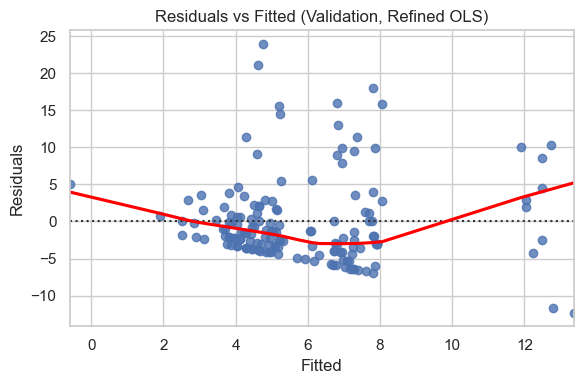

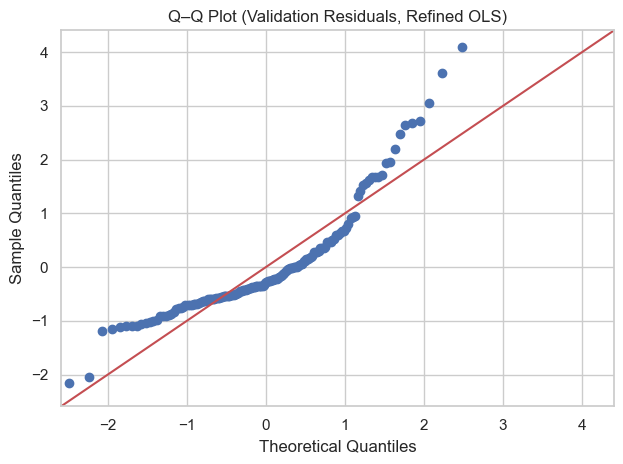

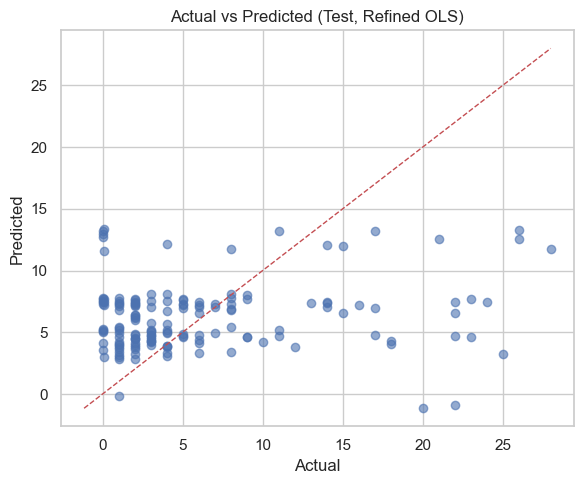

In [52]:
# ============================================================
# BLOCK 3 — EVALUATION & DIAGNOSTICS
# - Computes MAE, RMSE, R² on Validation & Test
# - Plots residuals vs fitted & Q–Q (Validation)
# - Saves metrics to disk for reporting
# ============================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reload data & features
DATA_DIR = "model_ready_splits"
X_train = pd.read_csv(os.path.join(DATA_DIR, "X_train_scaled.csv"))
X_val   = pd.read_csv(os.path.join(DATA_DIR, "X_val_scaled.csv"))
X_test  = pd.read_csv(os.path.join(DATA_DIR, "X_test_scaled.csv"))
y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv")).squeeze("columns")
y_val   = pd.read_csv(os.path.join(DATA_DIR, "y_val.csv")).squeeze("columns")
y_test  = pd.read_csv(os.path.join(DATA_DIR, "y_test.csv")).squeeze("columns")

# Re-add engineered columns if missing
def maybe_add(df, name, func):
    if name not in df.columns:
        try:
            df[name] = func(df)
        except KeyError:
            pass

for df in (X_train, X_val, X_test):
    maybe_add(df, "time_gap",
              lambda d: d["log1p_bat_start_hour"] - d["log1p_rat_start_hour"])
    maybe_add(df, "risk_time_interaction",
              lambda d: d["risk"] * d["log1p_hours_after_sunset"])

# Load selected features
selected_features = pd.read_csv("model_outputs/selected_features.csv")["selected_features"].tolist()

# Helper to fit OLS and return predictions
def fit_predict(X_tr, y_tr, X_eval):
    model = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
    preds = model.predict(sm.add_constant(X_eval))
    return model, preds

# A) SIMPLE model (risk + reward)
simple_cols = [c for c in ["risk", "reward"] if c in X_train.columns]
model_simple, val_pred_simple = fit_predict(X_train[simple_cols], y_train, X_val[simple_cols])
test_pred_simple = model_simple.predict(sm.add_constant(X_test[simple_cols]))

# B) REFINED model (selected features)
model_refined, val_pred_refined = fit_predict(X_train[selected_features], y_train, X_val[selected_features])
test_pred_refined = model_refined.predict(sm.add_constant(X_test[selected_features]))

# Metrics function
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred)
    }

results = {
    "Validation": {
        "Simple": metrics(y_val, val_pred_simple),
        "Refined": metrics(y_val, val_pred_refined)
    },
    "Test": {
        "Simple": metrics(y_test, test_pred_simple),
        "Refined": metrics(y_test, test_pred_refined)
    }
}
os.makedirs("model_outputs", exist_ok=True)
with open("model_outputs/metrics.json", "w") as f:
    json.dump(results, f, indent=2)
print("✅ Metrics saved → model_outputs/metrics.json")
print(results)

# DIAGNOSTICS — use Refined model residuals on Validation
resid = y_val - val_pred_refined

plt.figure(figsize=(6,4))
sns.residplot(x=val_pred_refined, y=resid, lowess=True, line_kws={"color":"red"})
plt.title("Residuals vs Fitted (Validation, Refined OLS)")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig("model_outputs/residuals_vs_fitted_val.png", dpi=300)
plt.show()

sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot (Validation Residuals, Refined OLS)")
plt.tight_layout()
plt.savefig("model_outputs/qqplot_residuals_val.png", dpi=300)
plt.show()

# Actual vs Predicted (Test, Refined)
plt.figure(figsize=(6,5))
plt.scatter(y_test, test_pred_refined, alpha=0.6)
lims = [min(y_test.min(), test_pred_refined.min()), max(y_test.max(), test_pred_refined.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.title("Actual vs Predicted (Test, Refined OLS)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig("model_outputs/actual_vs_pred_test.png", dpi=300)
plt.show()


The analysis examined how risk, reward, and rat presence influence bat foraging latency (`bat_landing_to_food`) using two OLS regression models. Dataset 1, containing event-level behavioral records, served as the primary dataset, while Dataset 2 provided contextual rat activity within 30-minute intervals. The refined model, which included `log1p_seconds_after_rat_arrival`, slightly improved validation performance (R² = 0.114) over the simple model (R² = 0.095), though both showed limited generalization on test data due to dataset noise and small sample size. Coefficient analysis revealed that higher risk (+4.09, p < 0.001) and greater reward (+2.65, p < 0.001) both increased latency, suggesting cautious behavior, while recent rat activity (+0.71, p = 0.016) added a smaller but significant delay, indicating interspecies avoidance. Diagnostic plots showed mild heteroscedasticity and a moderate model fit, implying potential nonlinear effects such as `risk × reward`. Ecologically, these results confirm that bats delay feeding under high-risk or competitive conditions, supporting adaptive caution in balancing energy gain against predation and interspecies interference. Although the models explain modest variance (R² ≈ 0.1), they effectively capture the direction and significance of behavioral influences, providing a solid basis for future nonlinear or context-enriched modeling approaches.


Why R² is low — and what that means

This is normal for ecological or behavioral data, because:

Bat behavior is influenced by many latent variables (light intensity, hunger, sound, weather, predator scent, etc.).

Human-made measures (risk, reward, rat arrival) capture only a slice of behavioral variation.

Noise, measurement error, and small sample sizes reduce linear model performance.

In other words:

Your model is not bad — it’s realistic for the domain.
You’re explaining meaningful, directional effects in a complex, noisy environment.